## Aim of the Study
The goal of this study is to investigate the factors influencing students’ academic stress levels and to evaluate predictive modeling approaches for estimating those stress levels. Using survey data on academic pressures, coping strategies, study environments, and personal habits, we apply both ordinal-aware and standard classification techniques to predict the Academic Stress Index. By comparing Ordinal Ridge Regression and Multinomial Logistic Regression in terms of exact-match accuracy and ±1 category accuracy, we aim to determine which method provides more accurate and practically useful predictions, as well as identify the most influential factors contributing to academic stress.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mord as m  # for ordinal logistic regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
pd.set_option('display.expand_frame_repr', False)  # keep everything on one line
warnings.filterwarnings('ignore')

## Read in Data and EDA 

In [2]:
df = pd.read_csv("/Users/emudr/Desktop/data/academicStress.csv")
print(df.describe().head(5))
print(df.info())
print(df.isna().sum())
print(df.duplicated().sum())

       Peer pressure  Academic pressure from your home  What would you rate the academic  competition in your student life  Rate your academic stress index 
count     121.000000                        121.000000                                         121.000000                                         121.000000
mean        3.008264                          3.190083                                           3.553719                                           3.669421
std         1.083942                          1.260384                                           0.991215                                           1.059783
min         1.000000                          1.000000                                           1.000000                                           1.000000
25%         2.000000                          2.000000                                           3.000000                                           3.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entr

## Data Cleaning

In [3]:
df.rename(columns = {'Your Academic Stage' : 'academic_stage', 
                     'Peer pressure' : 'peer_pressure', 
                     'Academic pressure from your home' : 'home_pressure', 
                     'Study Environment':'study_environment', 
                     'What coping strategy you use as a student?' : 'coping_strategy', 
                     'Do you have any bad habits like smoking, drinking on a daily basis?' : 'bad_habits', 
                     'What would you rate the academic  competition in your student life' : 'academic_competition', 
                     'Rate your academic stress index ' : 'stress_index'}, inplace = True)
print(df.describe().head(5))
print(df.info())

       peer_pressure  home_pressure  academic_competition  stress_index
count     121.000000     121.000000            121.000000    121.000000
mean        3.008264       3.190083              3.553719      3.669421
std         1.083942       1.260384              0.991215      1.059783
min         1.000000       1.000000              1.000000      1.000000
25%         2.000000       2.000000              3.000000      3.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Timestamp             121 non-null    object
 1   academic_stage        121 non-null    object
 2   peer_pressure         121 non-null    int64 
 3   home_pressure         121 non-null    int64 
 4   study_environment     121 non-null    object
 5   coping_strategy       121 non-null    object
 6   bad_habits            121 non-null    object
 7   academic_

## Data Visualization

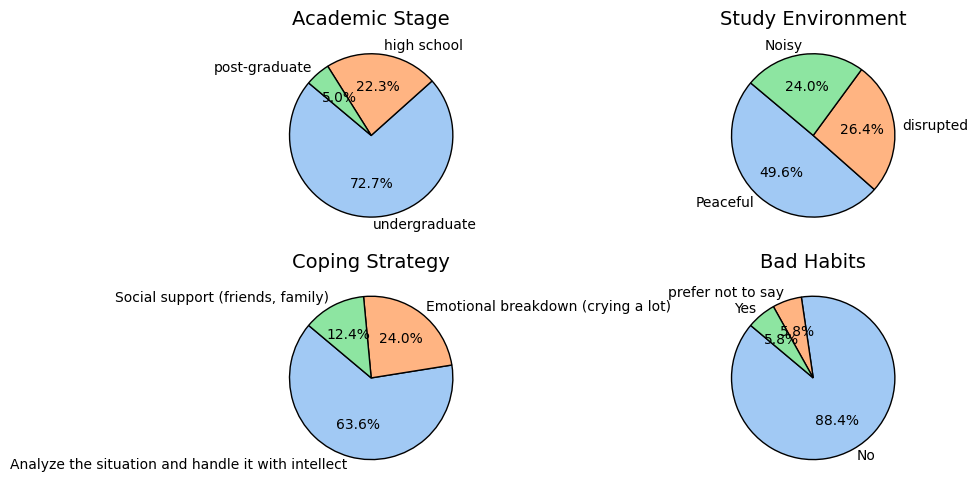

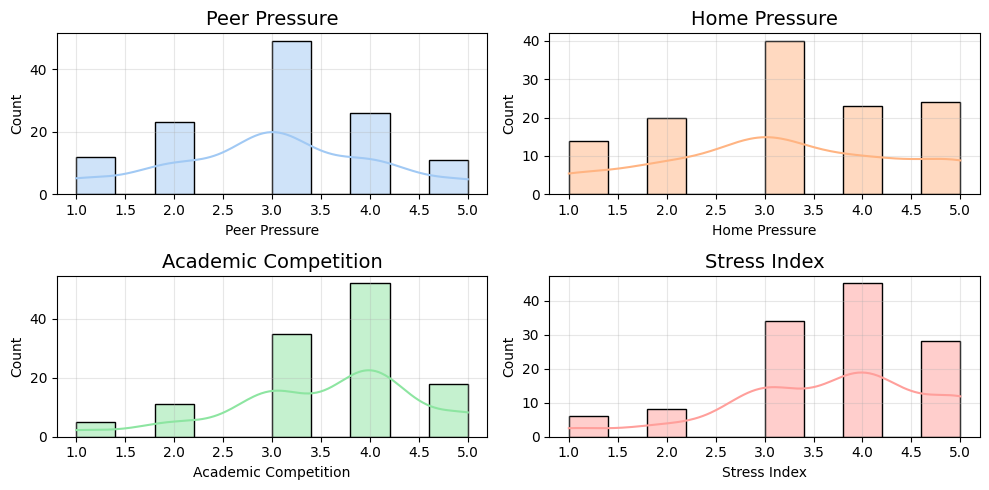

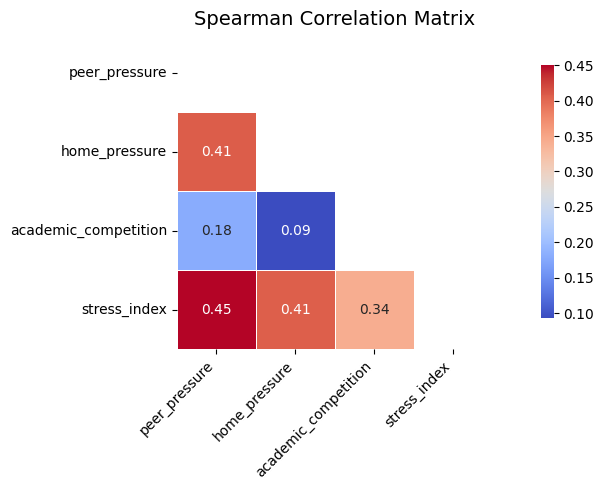

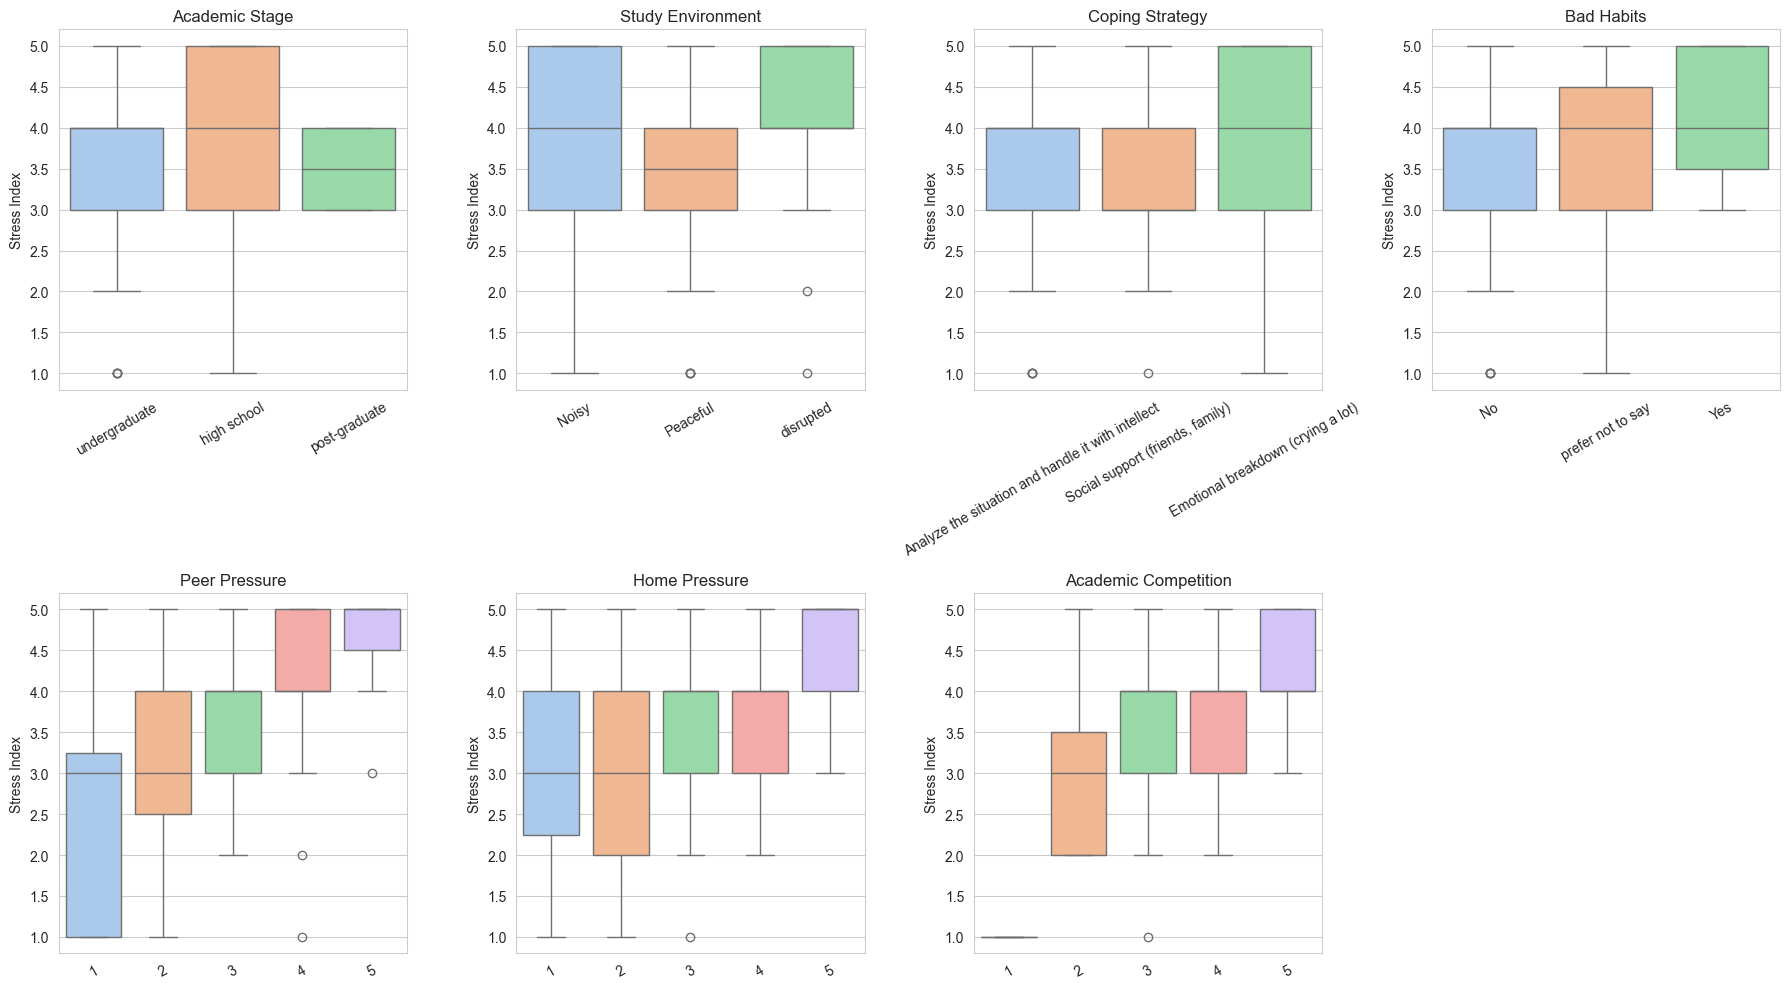

In [4]:
cat_vars = ['academic_stage', 'study_environment', 'coping_strategy', 'bad_habits']
num_vars = ['peer_pressure', 'home_pressure', 'academic_competition', 'stress_index']

## Pie plots
fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, cat_var in enumerate(cat_vars):
    value_counts = df[cat_var].value_counts(dropna=False)
    wedges, texts, autotexts = axs[i].pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        colors=colors, 
        startangle=140, 
        wedgeprops={'edgecolor': 'k'}
    )
    axs[i].set_title(cat_var.replace('_',' ').title(), fontsize=14)

plt.tight_layout()
plt.show()


## Histplots
fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs = axs.flatten()
colors = sns.color_palette("pastel")

for i, num_var in enumerate(num_vars):
    sns.histplot(df[num_var], kde=True, ax=axs[i], color=colors[i % len(colors)], edgecolor='k', bins=10)
    axs[i].set_title(num_var.replace('_',' ').title(), fontsize=14)
    axs[i].set_xlabel(num_var.replace('_',' ').title())
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Correlation Matrix
plt.figure(figsize=(10,5))
corr = df.corr(method='spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    mask=mask, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}, 
    square=True,
    annot_kws={"size":10}
)
plt.title("Spearman Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Boxplots
all_vars = ['academic_stage', 'study_environment', 'coping_strategy', 'bad_habits', 'peer_pressure', 'home_pressure', 'academic_competition']

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs = axs.flatten()

for i, var in enumerate(all_vars):
    sns.boxplot(x=var, y='stress_index', data=df, ax=axs[i], palette='pastel')
    axs[i].set_title(var.replace('_', ' ').title(), fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Stress Index', fontsize=10)
    axs[i].tick_params(axis='x', rotation=30)

# Remove the unused subplot
if len(all_vars) < len(axs):
    for j in range(len(all_vars), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## Modeling

## Data Preprocessing

In [5]:
features = ['peer_pressure', 'home_pressure', 'academic_competition', 'academic_stage', 'study_environment', 'coping_strategy', 'bad_habits']
target = 'stress_index'

# Assign X and y
X = df[features]
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------
# Preprocessing Pipeline
# ------------------------
numeric_features = ['peer_pressure', 'home_pressure', 'academic_competition']
categorical_features = ['academic_stage', 'study_environment', 'coping_strategy', 'bad_habits']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

## Model Comparison - Exact Match Accuracy

In this section, we build and evaluate two different models to predict the academic stress index:

1. **Ordinal Ridge Regression** (from the `mord` library) – suited for predicting ordered categories, 
   such as stress levels. We perform hyperparameter tuning on the `alpha` regularization strength 
   using cross-validation, train the model, and evaluate it using exact-match accuracy on the test set.
   We also extract and rank feature importances based on the absolute value of their coefficients.

2. **Multinomial Logistic Regression** – a general classification approach for predicting 
   multiple categories without assuming any order. This model is trained using a pipeline 
   that includes preprocessing steps (scaling numeric features, one-hot encoding categorical ones), 
   and is evaluated using exact-match accuracy as well. Coefficients are used to measure 
   feature importance.

The results allow us to compare how an ordinal-aware model and a standard multi-class classifier 
perform on the same prediction task.


In [6]:
# ------------------------
# 1. Ordinal Ridge Regression
# ------------------------
# Encode training data for mord
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

alphas = [0.01, 0.1, 1.0, 10.0]
grid = GridSearchCV(m.OrdinalRidge(), param_grid={'alpha': alphas}, cv=5)
grid.fit(X_train_encoded, y_train)
print("Best alpha (Ordinal Ridge):", grid.best_params_['alpha'])

ord_model = m.OrdinalRidge(alpha=grid.best_params_['alpha'])
ord_model.fit(X_train_encoded, y_train)
y_pred_ord = ord_model.predict(X_test_encoded)

# Exact match accuracy
accuracy_ord = (y_test == y_pred_ord).mean()

# Feature importance
ord_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ord_model.coef_
})
ord_coef_df['Importance'] = ord_coef_df['Coefficient'].abs()
ord_coef_df = ord_coef_df.sort_values(by='Importance', ascending=False)

print("\n=== Ordinal Ridge Regression ===")
print(f"Exact Match Accuracy (test): {accuracy_ord:.3f}")
print(ord_coef_df.head(10))



# ------------------------
# 2. Multinomial Logistic Regression
# ------------------------
log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
])
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

accuracy_log = (y_test == y_pred_log).mean()

# Coefficients
coef_log = log_model.named_steps['classifier'].coef_[0]
log_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_log,
})
log_coef_df['Importance'] = log_coef_df['Coefficient'].abs()
log_coef_df = log_coef_df.sort_values(by='Importance', ascending=False)

print("\n=== Multinomial Logistic Regression ===")
print(f"Exact Match Accuracy (test): {accuracy_log:.3f}")
print(log_coef_df.head(10))

Best alpha (Ordinal Ridge): 0.01

=== Ordinal Ridge Regression ===
Exact Match Accuracy (test): 0.360
                                             Feature  Coefficient  Importance
3                       academic_stage_post-graduate    -0.798160    0.798160
2                               academic_competition     0.431194    0.431194
10                      bad_habits_prefer not to say     0.367586    0.367586
0                                      peer_pressure     0.334105    0.334105
9                                     bad_habits_Yes     0.298847    0.298847
8   coping_strategy_Social support (friends, family)     0.290690    0.290690
1                                      home_pressure     0.278285    0.278285
4                       academic_stage_undergraduate    -0.167218    0.167218
5                         study_environment_Peaceful    -0.148035    0.148035
6                        study_environment_disrupted    -0.105347    0.105347

=== Multinomial Logistic Regression ===

## Model Comparison - Predictions within ±1 Stress Level
In this section, we compare the same two approaches above (Ordinal Ridge Regression and Multinomial Logistic Regression) for predicting the academic stress index, using a ±1 category accuracy metric (predictions within one stress level of the true value are counted as correct).

In [7]:
# ------------------------
# 1. Ordinal Ridge Regression
# ------------------------
print("\n=== Ordinal Ridge Regression ===")
accuracy_ord = (np.abs(y_test - y_pred_ord) <= 1).mean()
print(f"±1 Category Accuracy (test): {accuracy_ord:.3f}")


# ------------------------
# 2. Multinomial Logistic Regression
# ------------------------
print("\n=== Multinomial Logistic Regression ===")
accuracy_log = (np.abs(y_test - y_pred_log) <= 1).mean()  # ±1 category accuracy
print(f"±1 Category Accuracy (test): {accuracy_log:.3f}")




=== Ordinal Ridge Regression ===
±1 Category Accuracy (test): 0.960

=== Multinomial Logistic Regression ===
±1 Category Accuracy (test): 0.880


## Results Summary

**Ordinal Ridge Regression**\
Exact-match accuracy (test): 36.0%\
±1 category accuracy: 96.0%\
Most influential predictors:
- Academic competition (+)
- Peer pressure (+)

**Multinomial Logistic Regression**\
Exact-match accuracy (test): 32.0%\
±1 category accuracy: 88.0%\
Most influential predictors:
- Academic competition 
- Home pressure 


**Interpretation:**
Both models performed better when allowing for a ±1 category margin, but the Ordinal Ridge Regression substantially outperformed Multinomial Logistic Regression in this relaxed metric (96% vs. 88%). Academic competition and peer pressure emerged as key predictors in both models, suggesting these are strong drivers of academic stress levels. However, the sign and relative magnitude of coefficients differed, reflecting the models’ differing treatment of the ordinal nature of the target.